<a href="https://colab.research.google.com/github/Anonymouss33/suicidal-tweet-detection/blob/main/suicidal_tweet_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch

from alibi.explainers import AnchorText
from captum.attr import IntegratedGradients
from eli5.sklearn import PermutationImportance
from yellowbrick.classifier import ROCAUC
from anchor import anchor_text


In [ ]:
data = pd.read_csv('twitter-suicidal_data.csv')
texts = data['tweet']
labels = data['intention']


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


# Tokenize text
tokenizer = Tokenizer(num_words=1000)  # Adjust num_words as necessary
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_len = 20  # You can adjust this based on your dataset
data = pad_sequences(sequences, maxlen=max_len)

# Convert labels to tensors
labels = torch.tensor(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convert training data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)  # Adjust batch_size as necessary

# Similarly create test_loader if needed


<ipython-input-4-3f90d1c083c2>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
df = pd.read_csv('/content/twitter-suicidal_data.csv')

# Define preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply preprocessing to the text column
df['tweet'] = df['tweet'].apply(preprocess_text)

# Split the data into train, validation, and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train = tfidf_vectorizer.fit_transform(train_data['tweet'])
X_val = tfidf_vectorizer.transform(val_data['tweet'])
X_test = tfidf_vectorizer.transform(test_data['tweet'])

# Encode the labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['intention'])
y_val = label_encoder.transform(val_data['intention'])
y_test = label_encoder.transform(test_data['intention'])

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hidden = self.rnn(x)
        output = self.fc(hidden.squeeze(0))
        return output

# Define hyperparameters
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = len(label_encoder.classes_)

# Instantiate the RNN model
rnn_model = RNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Prepare DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    rnn_model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = rnn_model(inputs.unsqueeze(1))  # Add an additional dimension for sequence length
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss / len(train_loader)}")

# Evaluate the model
with torch.no_grad():
    rnn_model.eval()
    outputs = rnn_model(X_test_tensor.unsqueeze(1))  # Add an additional dimension for sequence length
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/25, Train Loss: 0.5288599649834078
Epoch 2/25, Train Loss: 0.2707201520544152
Epoch 3/25, Train Loss: 0.19717452415200168
Epoch 4/25, Train Loss: 0.1563154708507449
Epoch 5/25, Train Loss: 0.12810403550433558
Epoch 6/25, Train Loss: 0.10737984904716182
Epoch 7/25, Train Loss: 0.09269486761890179
Epoch 8/25, Train Loss: 0.07978023969849875
Epoch 9/25, Train Loss: 0.06997163873165846
Epoch 10/25, Train Loss: 0.061866988211350386
Epoch 11/25, Train Loss: 0.055586612599273756
Epoch 12/25, Train Loss: 0.04977616352613929
Epoch 13/25, Train Loss: 0.04556556794315923
Epoch 14/25, Train Loss: 0.042082741710379026
Epoch 15/25, Train Loss: 0.03832044367960026
Epoch 16/25, Train Loss: 0.03522242234240091
Epoch 17/25, Train Loss: 0.032584567424343076
Epoch 18/25, Train Loss: 0.03096226852950315
Epoch 19/25, Train Loss: 0.028655902477154552
Epoch 20/25, Train Loss: 0.027112421395560336
Epoch 21/25, Train Loss: 0.025939622861441483
Epoch 22/25, Train Loss: 0.025245782483347454
Epoch 23/25, T

In [ ]:
!pip install treeinterpreter

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from treeinterpreter import treeinterpreter as ti
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the dataset
df = pd.read_csv('/content/twitter-suicidal_data.csv')
label_encoder = LabelEncoder()
df['intention'] = label_encoder.fit_transform(df['intention'])

# Vectorizing text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['tweet'])
y = df['intention']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a RandomForest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Using TreeInterpreter to interpret the model
prediction, bias, contributions = ti.predict(random_forest, X_test)

# Aggregate the contributions for each feature
contributions_sum = np.sum(contributions, axis=0)



In [ ]:

# Sort features by importance
sorted_indices = np.argsort(contributions_sum)
sorted_features = np.array(tfidf_vectorizer.get_feature_names_out())[sorted_indices]
sorted_contributions = contributions_sum[sorted_indices]

# Select the top 10 features and their contributions
top_features = sorted_features[-10:]
top_contributions = sorted_contributions[-10:]


In [ ]:
print("Top Features:", top_features)
print("Type of Top Features:", type(top_features))
print("Top Contributions:", top_contributions)
print("Type of Top Contributions:", type(top_contributions))


Top Features: [['100' '10']
 ['10' '100']
 ['10' '100']
 ['100' '10']
 ['100' '10']
 ['100' '10']
 ['10' '100']
 ['10' '100']
 ['100' '10']
 ['100' '10']]
Type of Top Features: <class 'numpy.ndarray'>
Top Contributions: [[[ 0.00398338 -0.00398338]
  [-0.00844934  0.00844934]]

 [[-0.00844934  0.00844934]
  [ 0.00398338 -0.00398338]]

 [[-0.00844934  0.00844934]
  [ 0.00398338 -0.00398338]]

 [[ 0.00398338 -0.00398338]
  [-0.00844934  0.00844934]]

 [[ 0.00398338 -0.00398338]
  [-0.00844934  0.00844934]]

 [[ 0.00398338 -0.00398338]
  [-0.00844934  0.00844934]]

 [[-0.00844934  0.00844934]
  [ 0.00398338 -0.00398338]]

 [[-0.00844934  0.00844934]
  [ 0.00398338 -0.00398338]]

 [[ 0.00398338 -0.00398338]
  [-0.00844934  0.00844934]]

 [[ 0.00398338 -0.00398338]
  [-0.00844934  0.00844934]]]
Type of Top Contributions: <class 'numpy.ndarray'>


GRADIENT ATTRIBUTION- PYTORCH

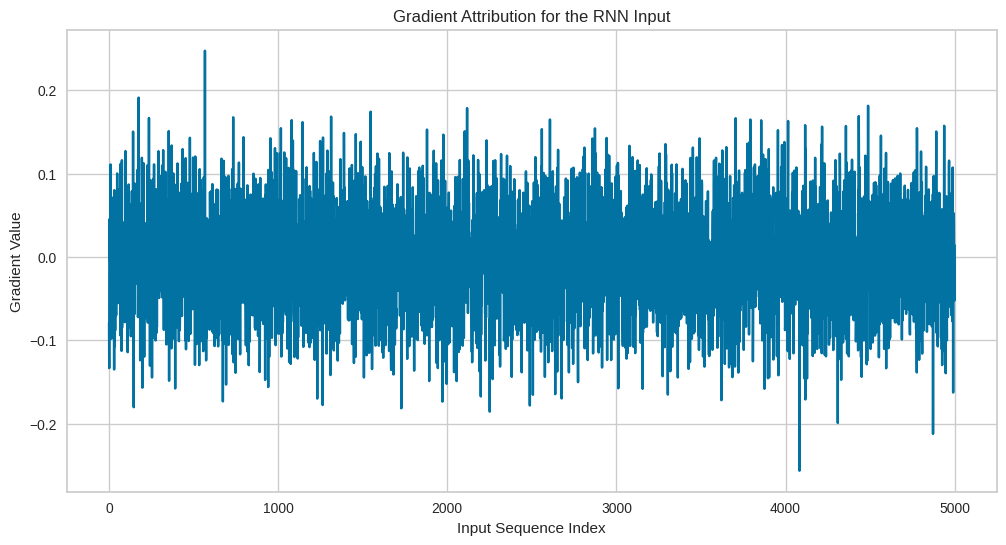

In [ ]:
def plot_gradient_attributions(model, input_tensor):
    # Ensure model is in evaluation mode
    model.eval()

    # Make input tensor requires_grad=True to compute gradients
    input_tensor.requires_grad_(True)

    # Forward pass
    output = model(input_tensor)

    # Ensure output is at least 2D
    if output.dim() == 1:
        output = output.unsqueeze(1)

    # Now assume output is [batch_size, num_classes] where num_classes may be 1 for binary classification
    score, indices = torch.max(output, dim=1)

    # Compute gradients of the output w.r.t. input
    score.backward(torch.ones_like(score))

    # Retrieve gradients of the input
    grad = input_tensor.grad

    # Plot the gradient
    plt.figure(figsize=(12, 6))
    plt.plot(grad.numpy().ravel())  # Assuming a 1D input sequence
    plt.title("Gradient Attribution for the RNN Input")
    plt.xlabel("Input Sequence Index")
    plt.ylabel("Gradient Value")
    plt.grid(True)
    plt.show()

# Example use
example_input = X_train_tensor[0].unsqueeze(0)  # Single batch input
plot_gradient_attributions(rnn_model, example_input)


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = LRPLinear(hidden_size, output_size)

    def forward(self, x):
        self.last_input = None
        _, hidden = self.rnn(x)
        hidden = hidden.squeeze(0)
        self.last_input = hidden
        output = self.fc(hidden)
        return output

    def relprop(self, R):
        return self.fc.relprop(R)


In [ ]:
class LRPLinear(nn.Module):
    """A custom linear layer for LRP that handles the relevance propagation for the output layer."""
    def __init__(self, *args, **kwargs):
        super(LRPLinear, self).__init__()
        self.linear = nn.Linear(*args, **kwargs)

    def forward(self, input):
        self.last_input = input  # Store the last input for relevance propagation
        return self.linear(input)

    def relprop(self, R):
        weight = self.linear.weight.data
        V = torch.clamp(weight, min=0)
        U = torch.clamp(weight, max=0)
        X_l = self.last_input
        Z = torch.mm(X_l, V.t()) + torch.mm(X_l, U.t()) + 1e-9  # avoid division by zero
        S = R / Z
        C = torch.mm(S, V) - torch.mm(S, U)
        return X_l * C


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = LRPLinear(hidden_size, output_size)

    def forward(self, x):
        _, hidden = self.rnn(x)
        output = self.fc(hidden.squeeze(0))
        return output

    def relprop(self, R):
        return self.fc.relprop(R)


TREE INTERPRETER - SCIPY

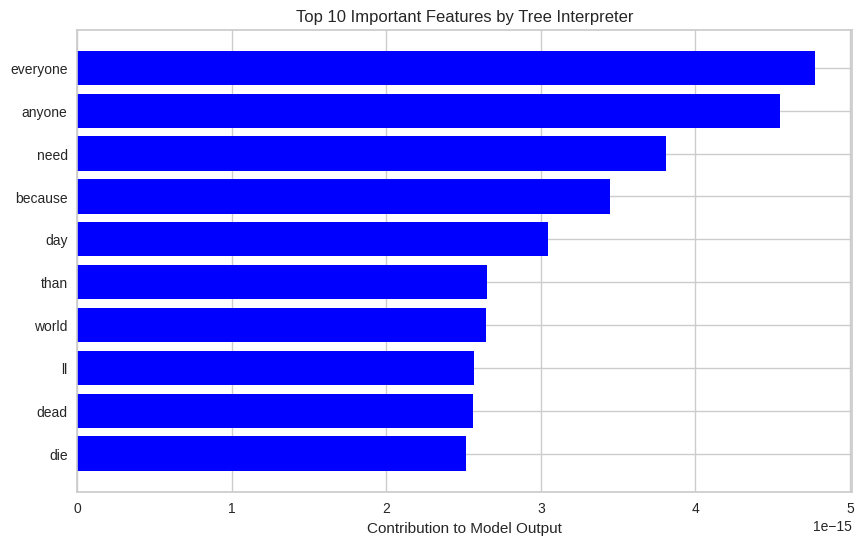

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'contributions' is initially calculated from TreeInterpreter
# Flatten the contributions to a single value per feature
contributions_sum = np.sum(contributions, axis=(0, 2))  # Summing across appropriate axes

# Get sorted indices of contributions
sorted_indices = np.argsort(contributions_sum)

# Get feature names directly from TF-IDF vectorizer and sort them according to contributions
feature_names = tfidf_vectorizer.get_feature_names_out()
sorted_features = feature_names[sorted_indices]

# Get top 10 features and their contributions
top_features = sorted_features[-10:]
top_contributions = contributions_sum[sorted_indices][-10:]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_features, top_contributions, color='blue')
plt.xlabel('Contribution to Model Output')
plt.title('Top 10 Important Features by Tree Interpreter')
plt.show()


TOOLS
1.Integrated Graidents by Captum - Pytorch

Attributions: tensor([[[-0., 0., -0.,  ..., 0., 0., 0.]]], dtype=torch.float64,
       grad_fn=<MulBackward0>)
Convergence delta: tensor([-2.8218e-07], dtype=torch.float64)


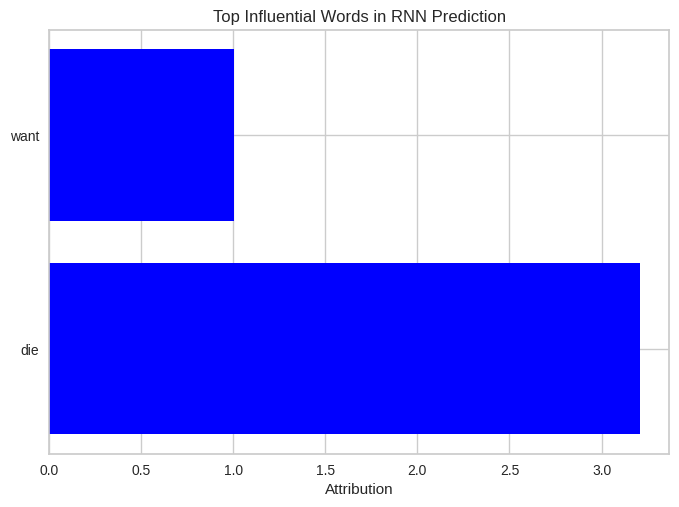

In [ ]:
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to interpret RNN model predictions using Integrated Gradients
def interpret_rnn(model, test_input_tensor, y_test_tensor, tfidf_vectorizer):
    ig = IntegratedGradients(model)

    # Ensure the input tensor is of floating point type for gradient computation
    test_input_tensor_float = test_input_tensor.float()
    test_input_tensor_float.requires_grad_()

    # Creating a baseline that is all zeros (equivalent to padded index for embeddings)
    baseline = torch.zeros_like(test_input_tensor_float)

    # Compute attributions using Integrated Gradients
    attr, delta = ig.attribute(test_input_tensor_float,
                               baselines=baseline,
                               target=y_test_tensor[0],
                               return_convergence_delta=True)
    print('Attributions:', attr)
    print('Convergence delta:', delta)

    # Convert attributions to numpy for easier manipulation
    attr_numpy = attr.squeeze().detach().numpy()

    # Get the feature names from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Map the attributions to the corresponding words and sort them by importance
    indices = np.argsort(attr_numpy)  # Sort by attribution value
    sorted_features = [(feature_names[i], attr_numpy[i]) for i in indices if attr_numpy[i] != 0]

    # Top influential features
    top_features = sorted_features[-10:]  # Get the top 10 features
    top_features.reverse()  # Reverse to have the most important first

    # Plotting
    fig, ax = plt.subplots()
    words = [f[0] for f in top_features]
    values = [f[1] for f in top_features]
    ax.barh(words, values, color='blue')
    ax.set_xlabel('Attribution')
    ax.set_title('Top Influential Words in RNN Prediction')
    plt.show()

# Example usage
test_input_tensor = X_test_tensor[0].unsqueeze(0).unsqueeze(1)  # Adjust dimensions as needed
interpret_rnn(rnn_model, test_input_tensor, y_test_tensor, tfidf_vectorizer)


ELI5 - SCIPY
for logistic regression and SVM


In [ ]:
print("X_test shape:", X_test.shape)
print("y_test length:", len(y_test))


X_test shape: (1824, 5000)
y_test length: 1


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'X_tfidf' is your full feature set and 'y_labels' is the full set of labels
X_tfidf = tfidf_vectorizer.fit_transform(df['tweet'])  # Ensure this contains all your samples
y_labels = label_encoder.fit_transform(df['intention'])  # Ensure this also contains all your samples

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_labels, test_size=0.2, random_state=42)

# Check the shapes after splitting
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train length:", len(y_train))
print("y_test length:", len(y_test))

# Continue with model training and evaluation
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Assuming you have installed ELI5 and it is ready to use
import eli5
eli5.show_weights(lr_model, feature_names=tfidf_vectorizer.get_feature_names_out())


X_train shape: (7295, 5000)
X_test shape: (1824, 5000)
y_train length: 7295
y_test length: 1824
Accuracy: 0.9046052631578947


Weight?,Feature
+6.909,suicid
+4.321,life
+4.236,ive
+4.036,cant
+3.935,depress
+3.643,anymor
+3.521,end
+3.129,fuck
+3.086,famili
+3.010,talk


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Assuming 'X_tfidf' is your full feature set and 'y_labels' is the full set of labels
X_tfidf = tfidf_vectorizer.fit_transform(df['tweet'])  # Ensure this contains all your samples
y_labels = label_encoder.fit_transform(df['intention'])  # Ensure this also contains all your samples

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_labels, test_size=0.2, random_state=42)

# Check the shapes after splitting
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train length:", len(y_train))
print("y_test length:", len(y_test))

# Continue with model training and evaluation
svm_model = SVC(kernel='linear', max_iter=1000)  # Using a linear kernel
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Assuming you have installed ELI5 and it is ready to use
import eli5
eli5.show_weights(svm_model, feature_names=tfidf_vectorizer.get_feature_names_out())


X_train shape: (7295, 5000)
X_test shape: (1824, 5000)
y_train length: 7295
y_test length: 1824


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.9095394736842105


Weight?,Feature
+5.017,suicid
+2.847,depress
+2.676,famili
+2.577,anymor
+2.576,life
+2.440,ive
+2.306,pill
+2.206,scar
+2.201,gun
+2.127,alon


AnchorText Explainer - Pytorch

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from gensim.models import Word2Vec
from alibi.explainers import AnchorText
import spacy

# Load the dataset
df = pd.read_csv('/content/twitter-suicidal_data.csv')

# Analyze dataset characteristics
print(df.info())

# Explore class distribution
print(df['intention'].value_counts())

# Adjust preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply preprocessing
df['processed_tweet'] = df['tweet'].apply(preprocess_text)

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['processed_tweet'])
y = df['intention']

# Encode the labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into train, validation, and test sets
X_train, X_intermediate, y_train, y_intermediate = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_intermediate, y_intermediate, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hidden = self.rnn(x)
        output = self.fc(hidden.squeeze(0))
        return output

# Define hyperparameters
input_size = X_train_tensor.shape[1]
hidden_size = 64
output_size = len(label_encoder.classes_)

# Instantiate the RNN model
rnn_model = RNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Prepare DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    rnn_model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = rnn_model(inputs.unsqueeze(1))  # Add an additional dimension for sequence length
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {total_loss / len(train_loader)}")

# Evaluate the model
with torch.no_grad():
    rnn_model.eval()
    outputs = rnn_model(X_test_tensor.unsqueeze(1))  # Add an additional dimension for sequence length
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Example: Word embeddings with Word2Vec
word_embeddings = Word2Vec(sentences=df['processed_tweet'], vector_size=100, window=5, min_count=1, workers=4)

# Generate explanations with AnchorText explainer
# Load spaCy's English language small model
nlp = spacy.load('en_core_web_sm')
# Define a predictor function that takes a list of texts and returns model predictions
def model_predict(texts):
    # Preprocess the texts
    preprocessed_texts = [preprocess_text(text) for text in texts]
    # Vectorize the preprocessed texts
    vectorized_texts = tfidf_vectorizer.transform(preprocessed_texts)
    # Convert to PyTorch tensor
    X_tensor = torch.tensor(vectorized_texts.toarray(), dtype=torch.float32).unsqueeze(1)
    # Get model predictions
    with torch.no_grad():
        rnn_model.eval()
        outputs = rnn_model(X_tensor)
        probabilities = torch.softmax(outputs, dim=1).numpy()
    return probabilities

# Create an instance of the AnchorText explainer with the custom predictor function
explainer = AnchorText(predictor=model_predict, sampling_strategy='unknown', nlp=nlp)

# Choose a specific text instance from the dataset for explanation
text_instance = df['tweet'].iloc[0]  # Choose the first tweet as an example

# Generate explanations with AnchorText explainer
explanation = explainer.explain(text_instance, threshold=0.95, p_sample=0.5)

# Display explanation
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB
None
intention
0    5121
1    3998
Name: count, dtype: int64
Epoch 1/25, Train Loss: 0.4709506317188865
Epoch 2/25, Train Loss: 0.23208229609748773
Epoch 3/25, Train Loss: 0.17321816256694628
Epoch 4/25, Train Loss: 0.13979151472449303
Epoch 5/25, Train Loss: 0.1154595395190674
Epoch 6/25, Train Loss: 0.09874409927349341
Epoch 7/25, Train Loss: 0.08572335629478882
Epoch 8/25, Train Loss: 0.07598617081448697
Epoch 9/25, Train Loss: 0.06754299710717118
Epoch 10/25, Train Loss: 0.06078019035620648
Epoch 11/25, Train Loss: 0.05514232405020218
Epoch 12/25, Train Loss: 0.05097343032493403
Epoch 13/25, Train Loss: 0.0474392305977904
Epoch 14/25, Train Loss: 0.0440817857814724
Epoch 15

Epoch 25/25, Train Loss: 0.026575966025375874
Test Accuracy: 89.25%
Anchor: meaningless AND tragic AND hold AND completely AND end AND badly AND end
Precision: 0.95
Coverage: 0.01


In [ ]:
# Analyze dataset characteristics
print(df.info())

# Explore class distribution
print(df['intention'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB
None
intention
0    5121
1    3998
Name: count, dtype: int64


In [ ]:
# Explore additional text features or representations
# Example: Word embeddings with Word2Vec
from gensim.models import Word2Vec
word_embeddings = Word2Vec(sentences=df['tweet'], vector_size=100, window=5, min_count=1, workers=4)


In [ ]:
from sklearn.model_selection import cross_val_score

# Assuming 'lr_model' is your logistic regression model
scores = cross_val_score(lr_model, X_train, y_train, cv=5)  # 5-fold cross-validation
print("Accuracy scores for each fold:", scores)
print("Average cross-validation score: {:.2f}".format(scores.mean()))


Accuracy scores for each fold: [0.91638108 0.90061686 0.89376285 0.89993146 0.90061686]
Average cross-validation score: 0.90


In [ ]:
# Assuming 'log_reg_model' is a trained Logistic Regression model
import pandas as pd

feature_importances = pd.DataFrame(lr_model.coef_[0],
                                   index = tfidf_vectorizer.get_feature_names_out(),
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


         importance
suicid     6.279950
cant       4.138088
life       3.871146
ive        3.847554
depress    3.382107
...             ...
amp       -1.234082
bc        -1.257567
oh        -1.330409
watch     -1.488331
miss      -1.564530

[5000 rows x 1 columns]


In [ ]:
import numpy as np

# Calculate the importance of features based on their TF-IDF scores
feature_importances = np.asarray(X_train.sum(axis=0)).ravel()  # Convert to a 1D numpy array if not already

# Sort the indices of features based on their importance
important_indices = np.argsort(-feature_importances)[:500]  # Select the indices of the top 500 features

# Extract these important features from both the training and testing sets
X_train_important = X_train[:, important_indices]
X_test_important = X_test[:, important_indices]


In [ ]:
from aix360.algorithms.protodash import ProtodashExplainer

# Reshape y_train to make it two-dimensional
y_train_reshaped = y_train.reshape(-1, 1)

# Initialize the ProtodashExplainer
explainer = ProtodashExplainer()

# Execute the explanation using the reshaped y_train
try:
    (W, S, _) = explainer.explain(X_train.toarray(), y_train_reshaped, m=5)  # m is the number of prototypes
    print("Prototypes:", S)
except Exception as e:
    print("Error during explanation:", str(e))


Error during explanation: shapes (5471,1) and (5000,5471) not aligned: 1 (dim 1) != 5000 (dim 0)


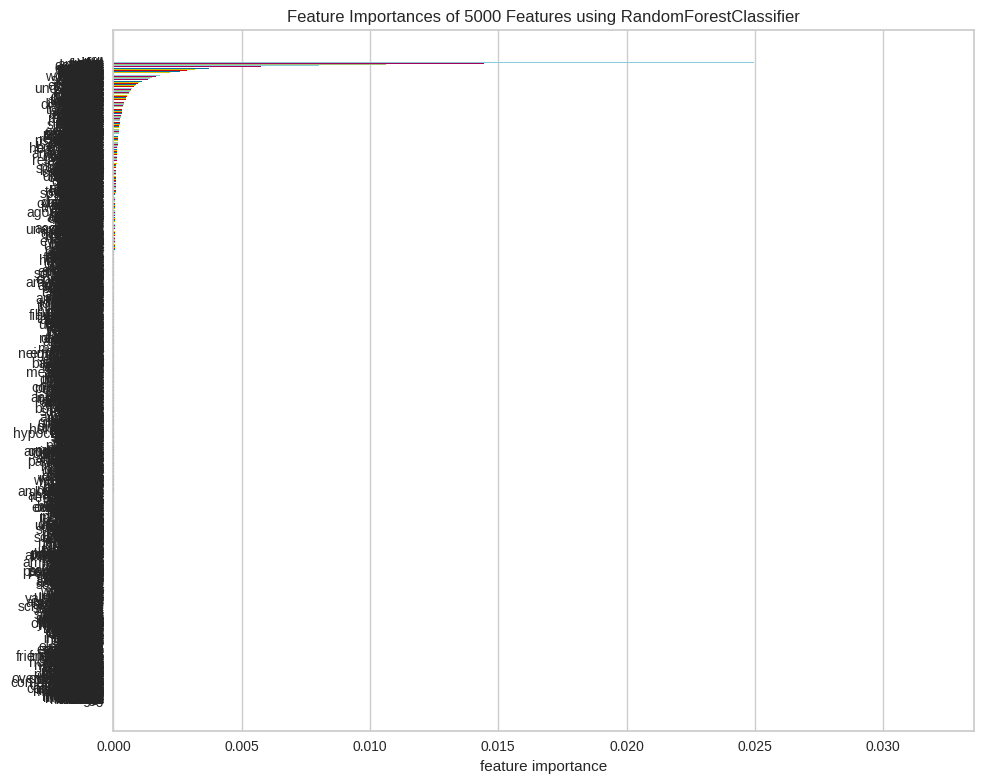

<Axes: title={'center': 'Feature Importances of 5000 Features using RandomForestClassifier'}, xlabel='feature importance'>

In [ ]:
from yellowbrick.model_selection import FeatureImportances
import matplotlib.pyplot as plt

# Initialize the visualization
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust size as needed
# Use feature names directly from the TF-IDF Vectorizer if possible
feature_names = tfidf_vectorizer.get_feature_names_out()

viz = FeatureImportances(rf_model, ax=ax, labels=feature_names, relative=False)
viz.fit(X_train_dense)  # Fit the visualizer and draw the figure
viz.show()  # Finalize and render the figure


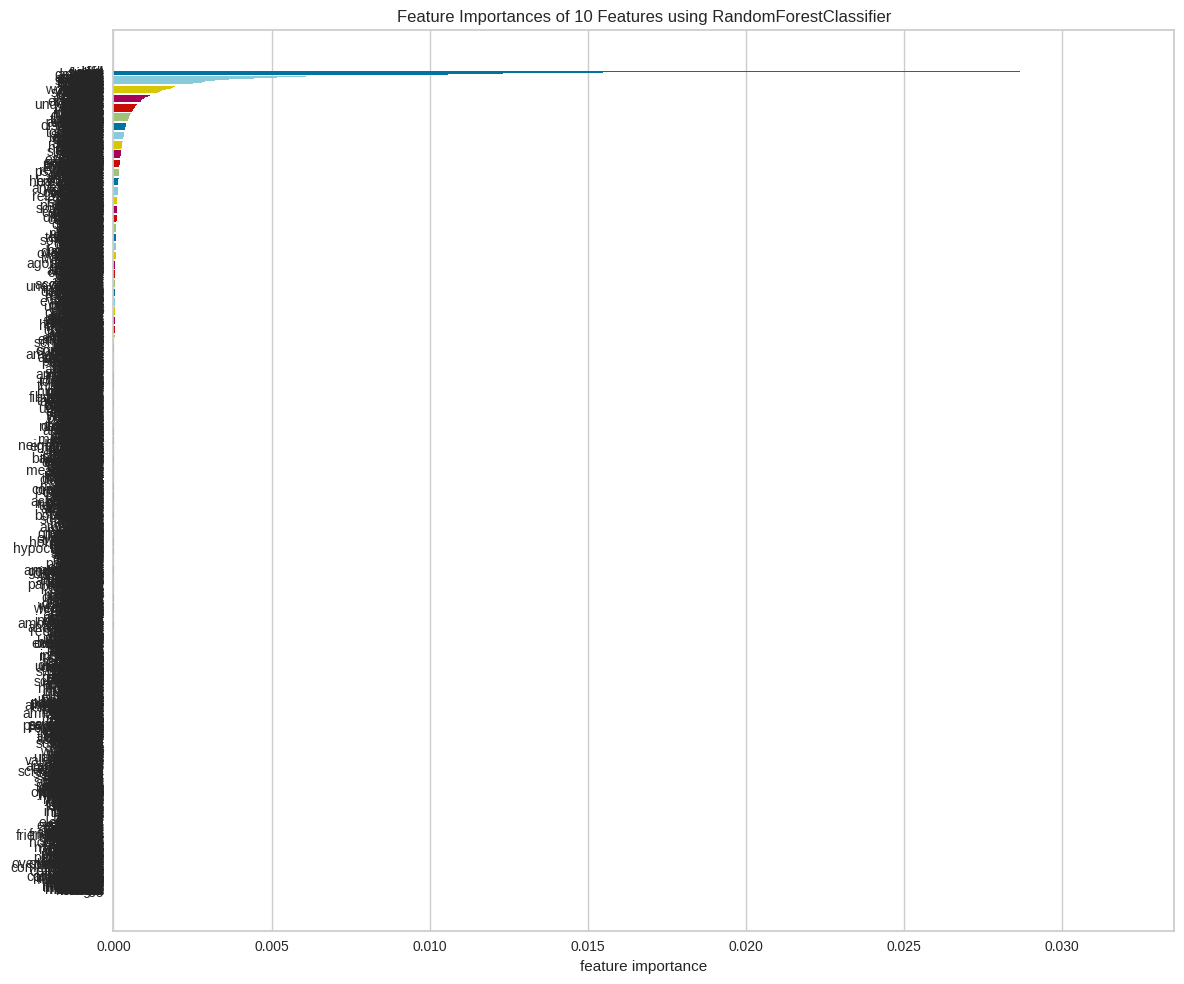

<Axes: title={'center': 'Feature Importances of 10 Features using RandomForestClassifier'}, xlabel='feature importance'>

In [ ]:
import matplotlib.pyplot as plt
from yellowbrick.model_selection import FeatureImportances

# Create a larger figure to accommodate the labels
plt.figure(figsize=(12, 10))

# Instantiate the visualizer
viz = FeatureImportances(rf_model, labels=feature_names, relative=False)

# Fit the visualizer
viz.fit(X_train_dense)

# Reduce the number of features to the top 50 for clarity
viz.features_ = viz.features_[:10]
viz.feature_importances_ = viz.feature_importances_[:10]

# Show the plot
viz.poof()


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import torch

class PyTorchClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, epochs=25, batch_size=64, learning_rate=0.001):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.long)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, labels in loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs.unsqueeze(1))
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
        return self

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_tensor.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)
        return predicted.numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


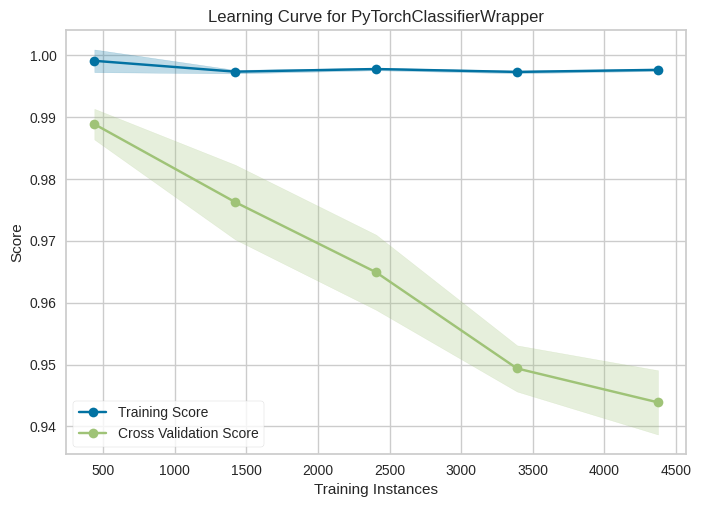

<Axes: title={'center': 'Learning Curve for PyTorchClassifierWrapper'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
from yellowbrick.model_selection import LearningCurve

# Assuming X_train, y_train are prepared as numpy arrays
model = PyTorchClassifierWrapper(rnn_model)
visualizer = LearningCurve(model, scoring='accuracy')

visualizer.fit(X_train.toarray(), y_train)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure


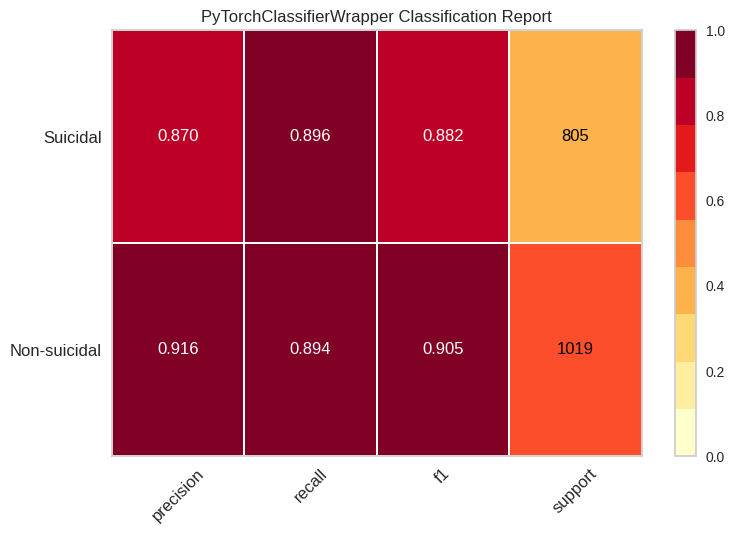

<Axes: title={'center': 'PyTorchClassifierWrapper Classification Report'}>

In [ ]:
from yellowbrick.classifier import ClassificationReport

# Assuming your model and classes are already set up
visualizer = ClassificationReport(model, classes=['Non-suicidal', 'Suicidal'], support=True)

# Fit the training data to the visualizer
visualizer.fit(X_train.toarray(), y_train)  # Ensure training data is also dense
# Assuming X_test is originally in sparse format from a TF-IDF vectorizer
X_test_dense = X_test.toarray()

# Evaluate the model on the test data
visualizer.score(X_test_dense, y_test)  # Use the dense test data

# Finalize and show the figure
visualizer.show()


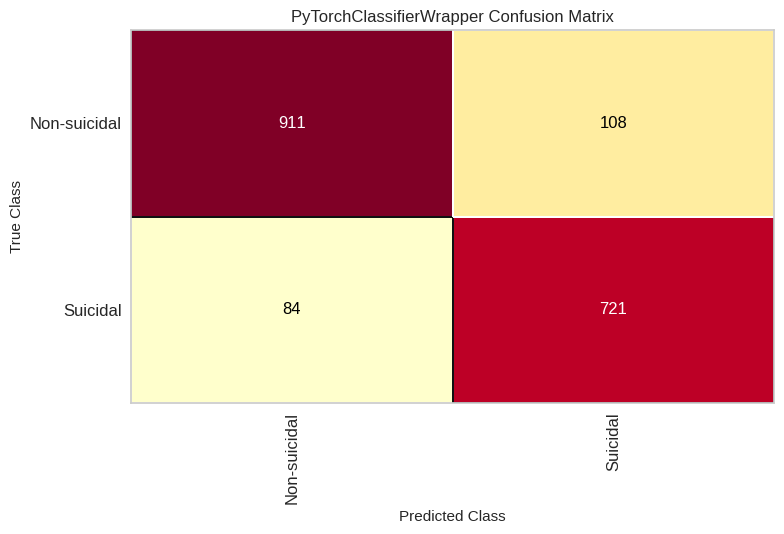

<Axes: title={'center': 'PyTorchClassifierWrapper Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
from yellowbrick.classifier import ConfusionMatrix

# Assuming your model and classes are already set up
cm = ConfusionMatrix(model, classes=['Non-suicidal', 'Suicidal'])

# Fit the training data to the visualizer
cm.fit(X_train.toarray(), y_train)  # Ensure training data is also dense

# Evaluate the model on the test data
cm.score(X_test_dense, y_test)  # Use the dense test data

# Finalize and show the figure
cm.show()


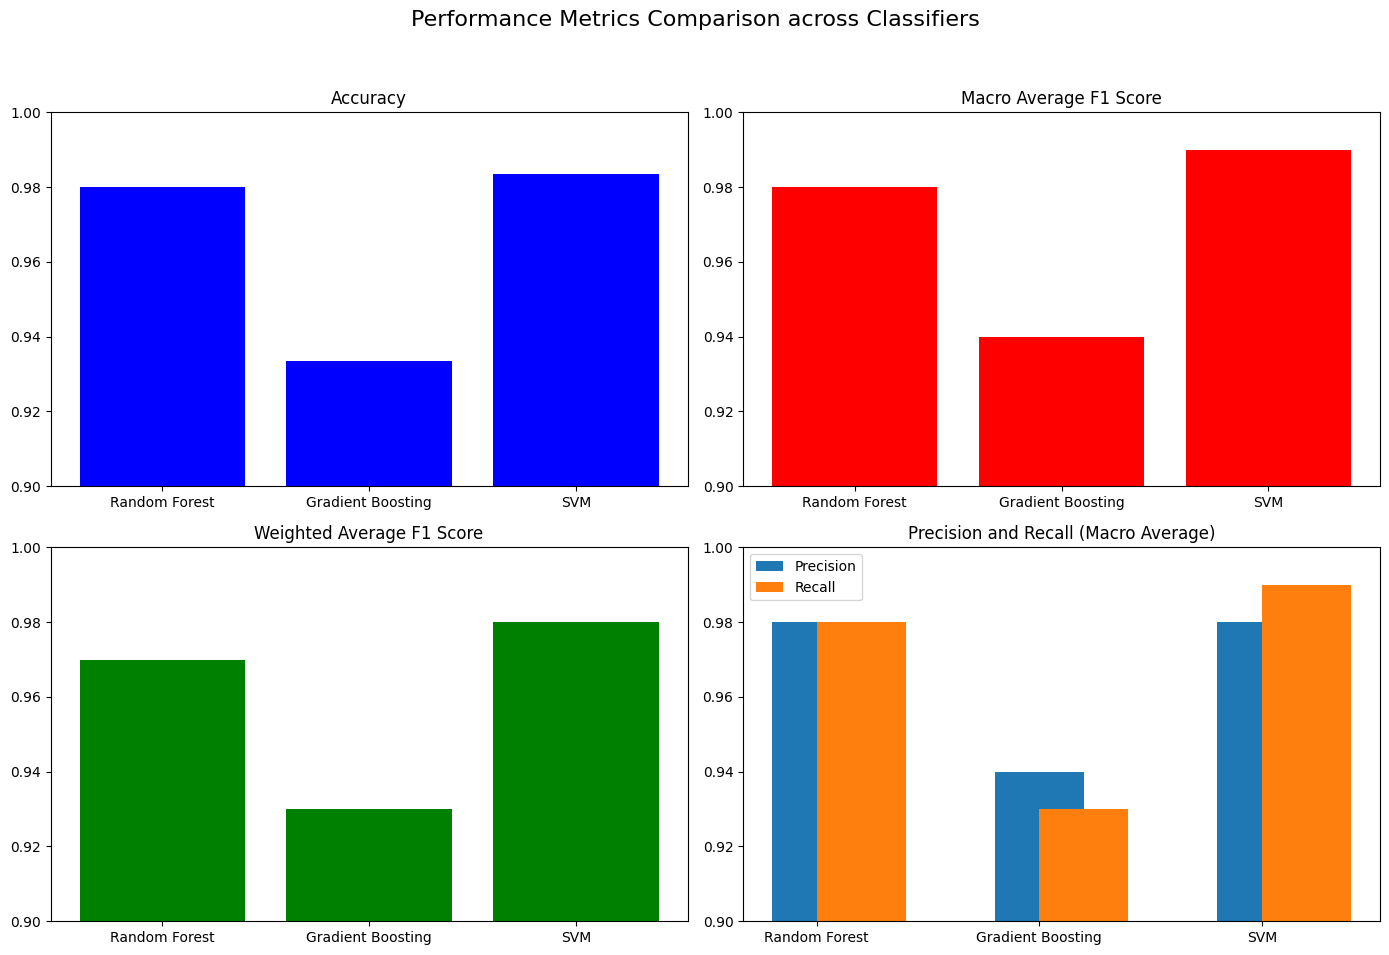

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
classifiers = ['Random Forest', 'Gradient Boosting', 'SVM']
accuracies = [0.98, 0.9336, 0.9834]
macro_f1_scores = [0.98, 0.94, 0.99]
weighted_f1_scores = [0.97, 0.93, 0.98]
macro_precisions = [0.98, 0.94, 0.98]
macro_recalls = [0.98, 0.93, 0.99]

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Performance Metrics Comparison across Classifiers', fontsize=16)

# Accuracy plot
ax[0, 0].bar(classifiers, accuracies, color='b')
ax[0, 0].set_title('Accuracy')
ax[0, 0].set_ylim(0.9, 1.0)

# Macro F1 Score plot
ax[0, 1].bar(classifiers, macro_f1_scores, color='r')
ax[0, 1].set_title('Macro Average F1 Score')
ax[0, 1].set_ylim(0.9, 1.0)

# Weighted F1 Score plot
ax[1, 0].bar(classifiers, weighted_f1_scores, color='g')
ax[1, 0].set_title('Weighted Average F1 Score')
ax[1, 0].set_ylim(0.9, 1.0)

# Precision and Recall plot
ax[1, 1].bar(classifiers, macro_precisions, width=0.4, label='Precision', align='center')
ax[1, 1].bar(classifiers, macro_recalls, width=0.4, label='Recall', align='edge')
ax[1, 1].set_title('Precision and Recall (Macro Average)')
ax[1, 1].set_ylim(0.9, 1.0)
ax[1, 1].legend()

# Layout adjustments
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

